In [1]:
!pip install kagglehub

In [2]:
import kagglehub
path = kagglehub.dataset_download("mohamedabdalgwad/skin-cancer")
print(path)

Using Colab cache for faster access to the 'skin-cancer' dataset.
/kaggle/input/skin-cancer


In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Import EfficientNetB3 and its specific preprocess_input
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess_input

from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight

In [4]:
DATA_DIR = DATA_DIR = "/kaggle/input/skin-cancer/skin caner"
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = 4
EPOCHS = 30

In [5]:
datagen = ImageDataGenerator(
    preprocessing_function=efficientnet_preprocess_input,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

class_names = list(train_gen.class_indices.keys())
print(class_names)

Found 1330 images belonging to 4 classes.
Found 330 images belonging to 4 classes.
['Normal', 'melanoma', 'nevus', 'pigmented benign keratosis']


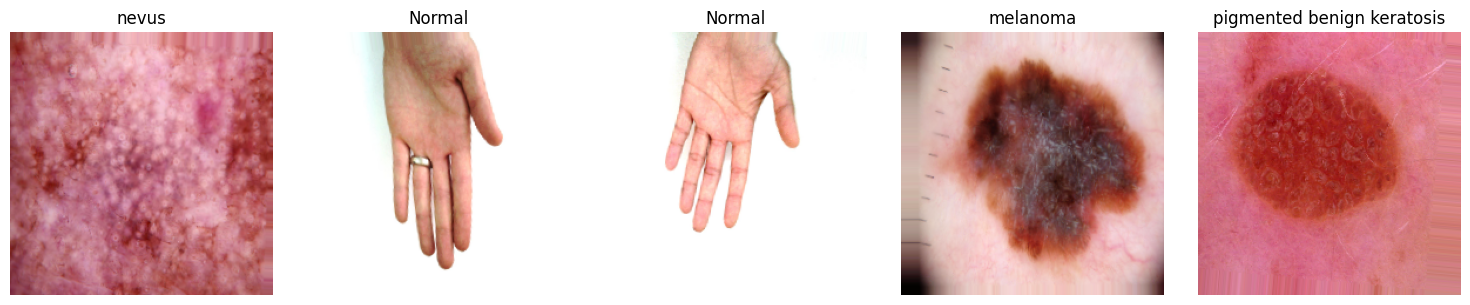

In [6]:
import random
import matplotlib.pyplot as plt

def show_random_images(generator, class_names, n=5):
    images, labels = next(generator)
    plt.figure(figsize=(15, 3))

    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        # Normalize images to [0, 1] for display purposes, handling potential out-of-range values
        img_display = images[i]
        min_val = np.min(img_display)
        max_val = np.max(img_display)
        if max_val > min_val:
            img_display = (img_display - min_val) / (max_val - min_val)
        else: # Handle cases where all pixel values are the same (e.g., solid color)
            img_display = np.zeros_like(img_display)

        plt.imshow(img_display)
        label = class_names[np.argmax(labels[i])]
        plt.title(label)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

show_random_images(train_gen, class_names)

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [8]:
callbacks = [
    EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=3, min_lr=1e-6),
    ModelCheckpoint("EfficientNetB3_SkinCancer.keras",
                    monitor="val_loss", save_best_only=True)
]


In [9]:
base_model = EfficientNetB3(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
outputs = Dense(NUM_CLASSES, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=outputs)

loss_fn = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)

model.compile(
    optimizer=Adam(1e-4),
    loss=loss_fn,
    metrics=["accuracy",
             tf.keras.metrics.Recall(name="recall")]
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        960 │ block1a_se_excit

 Total params: 11,178,035 (42.64 MB)

 Trainable params: 394,500 (1.50 MB)

 Non-trainable params: 10,783,535 (41.14 MB)

In [10]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 284s 6s/step - accuracy: 0.4366 - loss: 1.2730 - recall: 0.1804 - val_accuracy: 0.6636 - val_loss: 1.0028 - val_recall: 0.2545 - learning_rate: 1.0000e-04
Epoch 2/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 282s 7s/step - accuracy: 0.6326 - loss: 0.9504 - recall: 0.4585 - val_accuracy: 0.6788 - val_loss: 0.9513 - val_recall: 0.4545 - learning_rate: 1.0000e-04
Epoch 3/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 249s 6s/step - accuracy: 0.7006 - loss: 0.8672 - recall: 0.5536 - val_accuracy: 0.6818 - val_loss: 0.9450 - val_recall: 0.4879 - learning_rate: 1.0000e-04
Epoch 4/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 246s 6s/step - accuracy: 0.7621 - loss: 0.7976 - recall: 0.6152 - val_accuracy: 0.6879 - val_loss: 0.9136 - val_recall: 0.5000 - learning_rate: 1.0000e-04
Epoch 5/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 279s 7s/step - accuracy: 0.7535 - loss: 0.8086 - recall: 0.6241 - val_accuracy: 0.6848 - val_loss: 0.9269 - val_recall: 0.5121 - learning_rate: 1.0000e-04
Epoch 6/30
42/42 ━━━━━━━━━━━━━━━━━━

In [11]:
for layer in base_model.layers[-30:]:
    layer.trainable = True

model.compile(
    optimizer=Adam(1e-5),
    loss=loss_fn,
    metrics=["accuracy",
             tf.keras.metrics.Recall(name="recall")]
)

history_fine = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=callbacks
)


Epoch 1/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 312s 7s/step - accuracy: 0.6259 - loss: 1.0501 - recall: 0.3506 - val_accuracy: 0.6879 - val_loss: 0.9295 - val_recall: 0.5182 - learning_rate: 1.0000e-05
Epoch 2/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 282s 7s/step - accuracy: 0.6756 - loss: 0.9607 - recall: 0.3993 - val_accuracy: 0.6515 - val_loss: 0.9497 - val_recall: 0.4455 - learning_rate: 1.0000e-05
Epoch 3/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 284s 7s/step - accuracy: 0.6826 - loss: 0.9300 - recall: 0.4362 - val_accuracy: 0.6636 - val_loss: 0.9667 - val_recall: 0.4545 - learning_rate: 1.0000e-05
Epoch 4/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 278s 7s/step - accuracy: 0.7130 - loss: 0.8893 - recall: 0.4701 - val_accuracy: 0.6879 - val_loss: 0.9618 - val_recall: 0.4455 - learning_rate: 1.0000e-05
Epoch 5/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 323s 7s/step - accuracy: 0.6952 - loss: 0.9066 - recall: 0.4669 - val_accuracy: 0.6727 - val_loss: 0.9759 - val_recall: 0.4242 - learning_rate: 3.0000e-06
Epoch 6/15
42/42 ━━━━━━━━━━━━━━━━━━

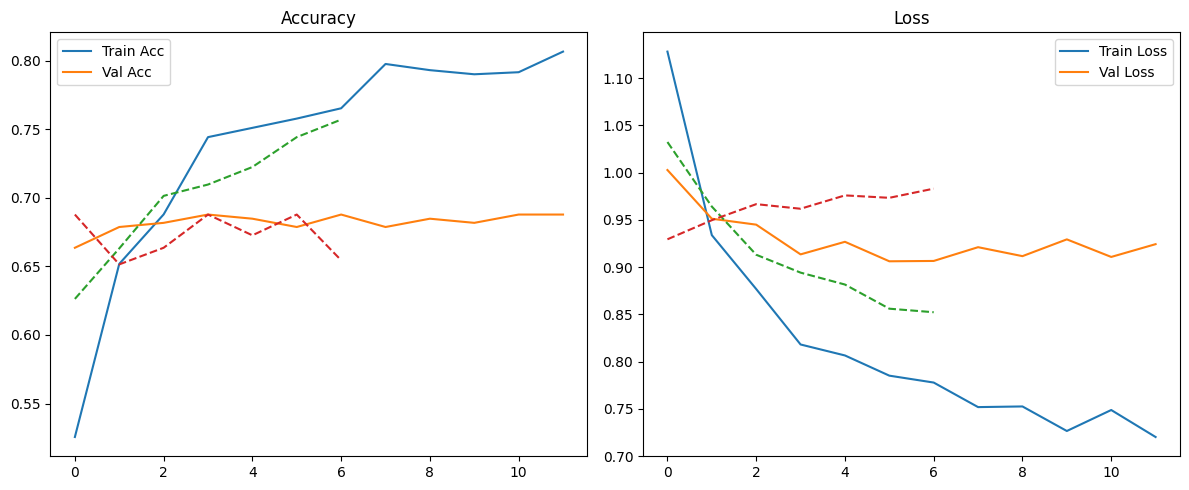

In [12]:
def plot_training(history, history_fine=None):
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(history.history["accuracy"], label="Train Acc")
    plt.plot(history.history["val_accuracy"], label="Val Acc")
    if history_fine:
        plt.plot(history_fine.history["accuracy"], linestyle="--")
        plt.plot(history_fine.history["val_accuracy"], linestyle="--")
    plt.legend()
    plt.title("Accuracy")

    plt.subplot(1,2,2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    if history_fine:
        plt.plot(history_fine.history["loss"], linestyle="--")
        plt.plot(history_fine.history["val_loss"], linestyle="--")
    plt.legend()
    plt.title("Loss")

    plt.tight_layout()
    plt.show()

plot_training(history, history_fine)

In [13]:
y_true = val_gen.classes
y_pred = np.argmax(model.predict(val_gen), axis=1)

11/11 ━━━━━━━━━━━━━━━━━━━━ 58s 5s/step


In [14]:
print(classification_report(
    y_true,
    y_pred,
    target_names=class_names,
    digits=4
))


                            precision    recall  f1-score   support

                    Normal     1.0000    0.9875    0.9937        80
                  melanoma     0.5682    0.2874    0.3817        87
                     nevus     0.4405    0.5211    0.4774        71
pigmented benign keratosis     0.6179    0.8261    0.7070        92

                  accuracy                         0.6576       330
                 macro avg     0.6566    0.6555    0.6399       330
              weighted avg     0.6592    0.6576    0.6413       330



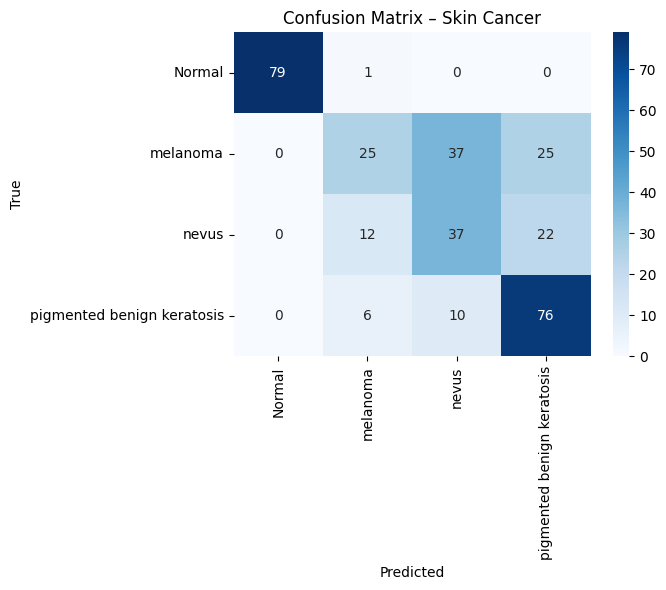

In [15]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=class_names,
            yticklabels=class_names,
            cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – Skin Cancer")
plt.tight_layout()
plt.show()

In [21]:
import tensorflow as tf
import cv2
import numpy as np

def grad_cam(model, img_array, last_conv_layer_name, class_idx=None):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if class_idx is None:
            class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

grad_cam(model, val_gen[0][0], "top_conv")


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)


array([[0.17929684, 0.4961814 , 0.7534062 , 0.7488923 , 0.6522468 ,
        0.53184754, 0.        ],
       [0.46156323, 0.5559335 , 0.9189142 , 1.        , 0.72053856,
        0.62199676, 0.32261086],
       [0.0720208 , 0.        , 0.45120102, 0.71395236, 0.48762685,
        0.5895296 , 0.45883146],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.18465403, 0.600153  ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.5258222 ],
       [0.1617083 , 0.        , 0.        , 0.        , 0.        ,
        0.09088117, 0.5669527 ],
       [0.27965584, 0.38267243, 0.29281133, 0.03250719, 0.10378317,
        0.26367754, 0.55631363]], dtype=float32)

1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step


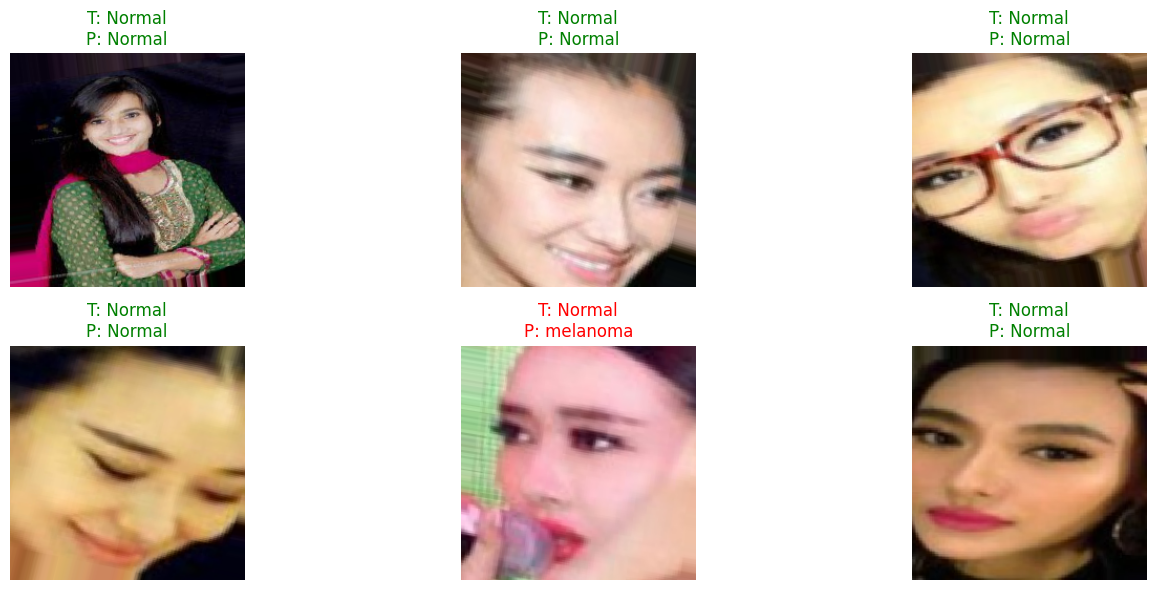

In [18]:
def show_predictions(model, generator, class_names, n=6):
    images, labels = next(generator)
    preds = model.predict(images)

    plt.figure(figsize=(15, 6))
    for i in range(n):
        ax = plt.subplot(2, 3, i + 1)
        # Normalize images to [0, 1] for display purposes, handling potential out-of-range values
        img_display = images[i]
        min_val = np.min(img_display)
        max_val = np.max(img_display)
        if max_val > min_val:
            img_display = (img_display - min_val) / (max_val - min_val)
        else: # Handle cases where all pixel values are the same (e.g., solid color)
            img_display = np.zeros_like(img_display)

        plt.imshow(img_display)

        true_label = class_names[np.argmax(labels[i])]
        pred_label = class_names[np.argmax(preds[i])]

        color = "green" if true_label == pred_label else "red"
        plt.title(f"T: {true_label}\nP: {pred_label}", color=color)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

show_predictions(model, val_gen, class_names)